In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, max_error

sns.set()

In [2]:
class BaselineCFBySGD:
    def __init__(self, number_epochs, alpha, reg, columns):
        self.number_epochs = number_epochs
        self.alpha = alpha
        self.reg = reg  # regularization
        self.columns = columns
    
    def fit(self, dataset):
        self.dataset = dataset
        self.user_ratings = dataset.groupby(self.columns[0]).agg([list])[[self.columns[1], self.columns[2]]]
        self.item_ratings = dataset.groupby(self.columns[1]).agg([list])[[self.columns[0], self.columns[2]]]
        self.global_mean = dataset[self.columns[2]].mean()
        
        self.bu, self.bi = self.sgd()
    
    def sgd(self):
        bu = dict(zip(self.user_ratings.index, np.zeros(len(self.user_ratings))))
        bi = dict(zip(self.item_ratings.index, np.zeros(len(self.item_ratings))))
        
        for i in range(self.number_epochs):
            print(f'iter {i}')
            for uid, iid, real_rating in self.dataset.itertuples(index=False):
                error = real_rating - (self.global_mean + bu[uid] + bi[iid])
                bu[uid] += self.alpha*(error - self.reg * bu[uid])
                bi[iid] += self.alpha*(error - self.reg * bi[iid])
        return bu, bi
    
    def predict(self):
        predict_rating = []
        for uid in self.user_ratings.index:
            for iid in self.item_ratings.index:
                predict_rating.append((uid, iid,  self.global_mean + self.bu[uid] + self.bi[iid]))
        return pd.DataFrame(predict_rating, columns=self.columns[:-1]+['prediction'])

In [3]:
dtype = [('userId', np.int32), ('movieId', np.int32), ('rating', np.float32)]
dataset = pd.read_csv('ml-latest-small/ratings.csv', dtype=dict(dtype), usecols=range(3))

In [4]:
bcf = BaselineCFBySGD(20, 0.1, 0.1, ['userId','movieId','rating'])
bcf.fit(dataset)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19


In [5]:
prediction = bcf.predict()

prediction

,userId,movieId,prediction
0,1,1,4.363069
1,1,2,4.282875
2,1,3,3.732900
3,1,4,3.170185
4,1,5,3.345300
...,...,...,...
5931635,610,193581,4.369263
5931636,610,193583,3.947016
5931637,610,193585,3.948741
5931638,610,193587,3.950293


# ---------------------------------------------

In [26]:
prediction_real = dataset.merge(prediction, how='inner', on=['userId','movieId'])
dataset.shape, prediction.shape

((100836, 3), (5931640, 3))

In [12]:
r2_score(prediction_real['rating'], prediction_real['prediction'])

0.31162539296237324

In [14]:
mean_absolute_error(prediction_real['rating'], prediction_real['prediction'])

0.6611546450322606

In [18]:
error = prediction_real['rating'] - prediction_real['prediction']

<AxesSubplot:title={'center':'Residual distribution'}, ylabel='Frequency'>

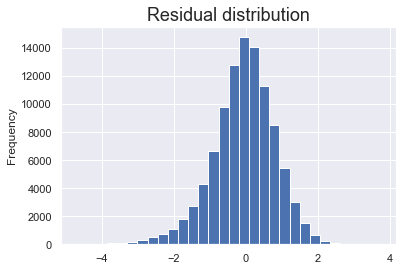

In [25]:
plt.title('Residual distribution', fontsize=18)
error.plot(kind='hist', bins=30)